### Не запускать все клетки сразу! Некоторые методы требуют много оперативной памяти.

In [91]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tqdm
import seaborn as sns
from sklearn.preprocessing import StandardScaler

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# игнорировать предупреждения
import warnings
warnings.filterwarnings("ignore")

Задаем некоторые константы, считываем данные, выкидываем лишнее и нормализуем.

In [92]:
colors = [
    'peru',
    'goldenrod',
    'cyan',
    'blue',
    'salmon',
    'darkred',
    'gold',
    'darkgreen',
    'indigo',
    'cyan',
    'darkblue'
]

In [93]:
data = pd.read_csv('housing.csv', delimiter=',')

In [94]:
scaler = StandardScaler()
data_scaled = data.copy()
for c in data.columns:
  data_scaled[c] = scaler.fit_transform(data[[c]])

In [95]:
data.shape

(70366, 3)

Смотрим, как выглядят контуры данных без кластеризации. Растягиваем по меркаторской проекции для 55 гр с.ш.

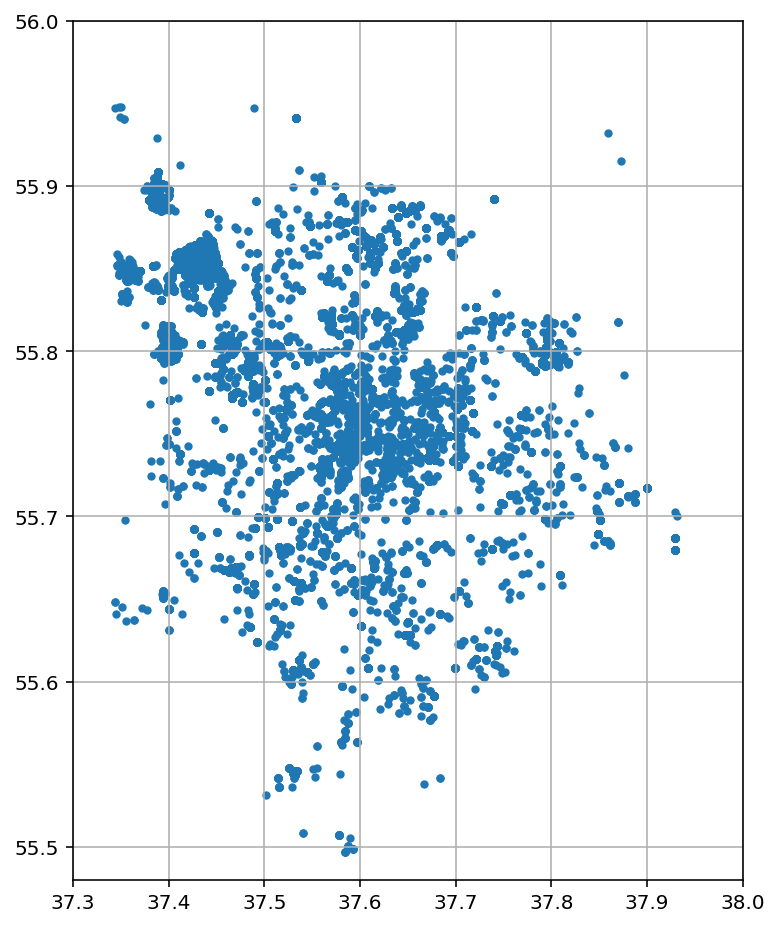

In [96]:
fig, ax = plt.subplots(figsize=(6, 4.5 / 0.57))
ax.set_autoscaley_on(False)
ax.set_xlim([37.3, 38])
ax.set_ylim([55.48, 56])
ax.scatter(data.x, data.y, s=10, zorder=1)
ax.grid()

In [97]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, AffinityPropagation
from sklearn.metrics import adjusted_rand_score, silhouette_score

Для KMeans можно посмотреть сколько он находит кластеров. Получается в районе 10, что хорошо коррелирует с картой.

In [98]:
k_inertia = []
ks = range(1,20)

for k in ks:
    clf_kmeans = KMeans(n_clusters=k)
    clusters_kmeans = clf_kmeans.fit_predict(data_scaled, )
    k_inertia.append(clf_kmeans.inertia_)

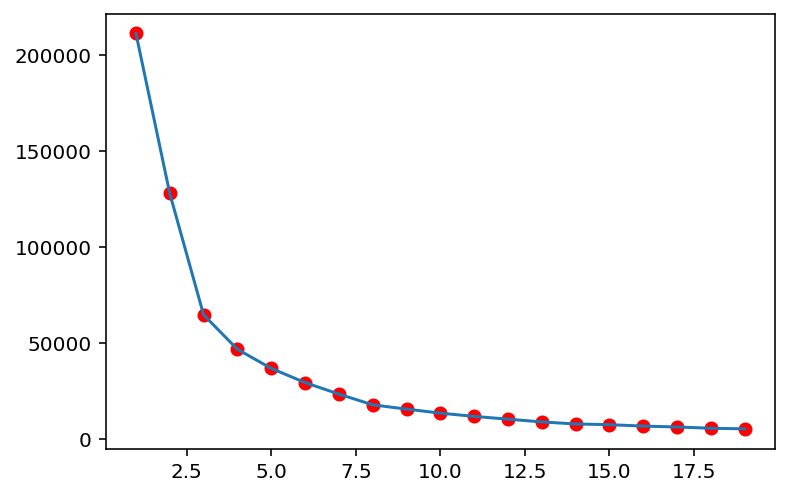

In [99]:
plt.plot(ks, k_inertia, 'ro')
plt.plot(ks, k_inertia);

Наша основная функция. Сюда передаем:
1. Алгоритм с его параметрами
2. Количество кластеров для отображения в сетке (для KMeans должно соответствовать n_clusters)
3. Список номеров кластеров для отображения. Если пуст -- будут показаны все.
4. Фильтр по голосам: 'both', 'yes', 'no'. По умолчанию отображаются все.

In [102]:
def calc_and_draw(kmeans, n, show = [], cc = 'both'):
    if (cc == 'both'):
        ds = data_scaled
        dt = data
    elif (cc == 'yes'):
        ds = data_scaled[data_scaled.comment_class > 0].reset_index(drop = True)
        dt = data[data.comment_class > 0].reset_index(drop = True)
    else:        
        ds = data_scaled[data_scaled.comment_class < 0].reset_index(drop = True)
        dt = data[data.comment_class < 0].reset_index(drop = True)
    
    clusters = kmeans.fit_predict(ds)
    
    unique_clusters = np.unique(clusters)
    
    print('Определено кластеров: {0}'.format(len(unique_clusters)))

    colored = []

    for c in clusters:
        if (c < n):
          colored.append(colors[c])
        else:
          colored.append('black')  

    x_std = dt.x.std()
    x_mean = dt.x.mean()
    y_std = dt.y.std()
    y_mean = dt.y.mean()

    fig, ax = plt.subplots(1, 2, figsize=(12, 3.85 / 0.57))

    for i in range(n):
        if (len(show) == 0 or i in show):
            indices = np.argwhere(clusters == i).flatten()
            d = dt.loc[indices]
            ax[0].scatter(d.x, d.y, s=20, c=colors[i], alpha=0.2);
            if (hasattr(kmeans, 'cluster_centers_')):                           
                centers = kmeans.cluster_centers_
                if (len(centers) > 0 and len(centers[0]) > 0):
                  ax[0].scatter(centers[i, 0] * x_std + x_mean, centers[i, 1] * y_std + y_mean, c='red', s=5)  

    ax[0].set_xlim([37.3, 38])
    ax[0].set_ylim([55.48, 56])           
    ax[0].grid()

    img = plt.imread("moscow.gif")
    ax[1].imshow(img)
    ax[1].grid()   

    fig, axes = plt.subplots(2, 5, figsize=(16, 9.5 / 0.57))

    for x in range(len(axes)):
        for y in range(len(axes[x])):
            i = x * 5 + y
            if (i < n):
                indices = np.argwhere(clusters == i).flatten()
                d = dt.loc[indices]
                ax = axes[x][y]
                ax.set_autoscaley_on(False)
                ax.scatter(d.x, d.y, s=40, c=colors[i]);
                ax.grid()
                ax.set_xlim([37.3, 38])
                ax.set_ylim([55.48, 56])
                if (hasattr(kmeans, 'cluster_centers_')):
                    centers = kmeans.cluster_centers_
                    if (len(centers) > 0 and len(centers[0]) > 0):
                      ax.scatter(centers[i, 0] * x_std + x_mean, centers[i, 1] * y_std + y_mean, c='red', s=10)                         
                
    

Собственно, как это работает. Вот KMeans для 9 районов. Все показываем, все голоса.

Определено кластеров: 9


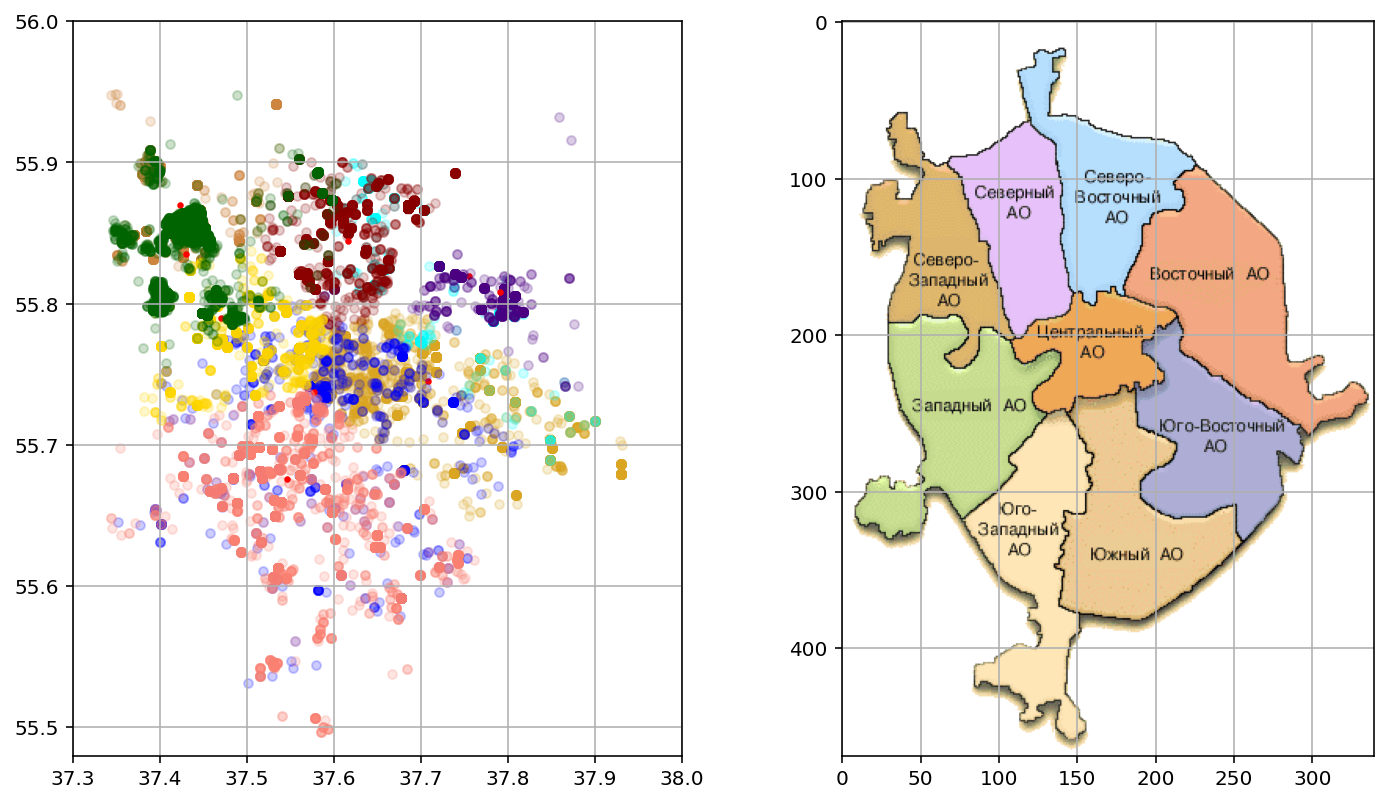

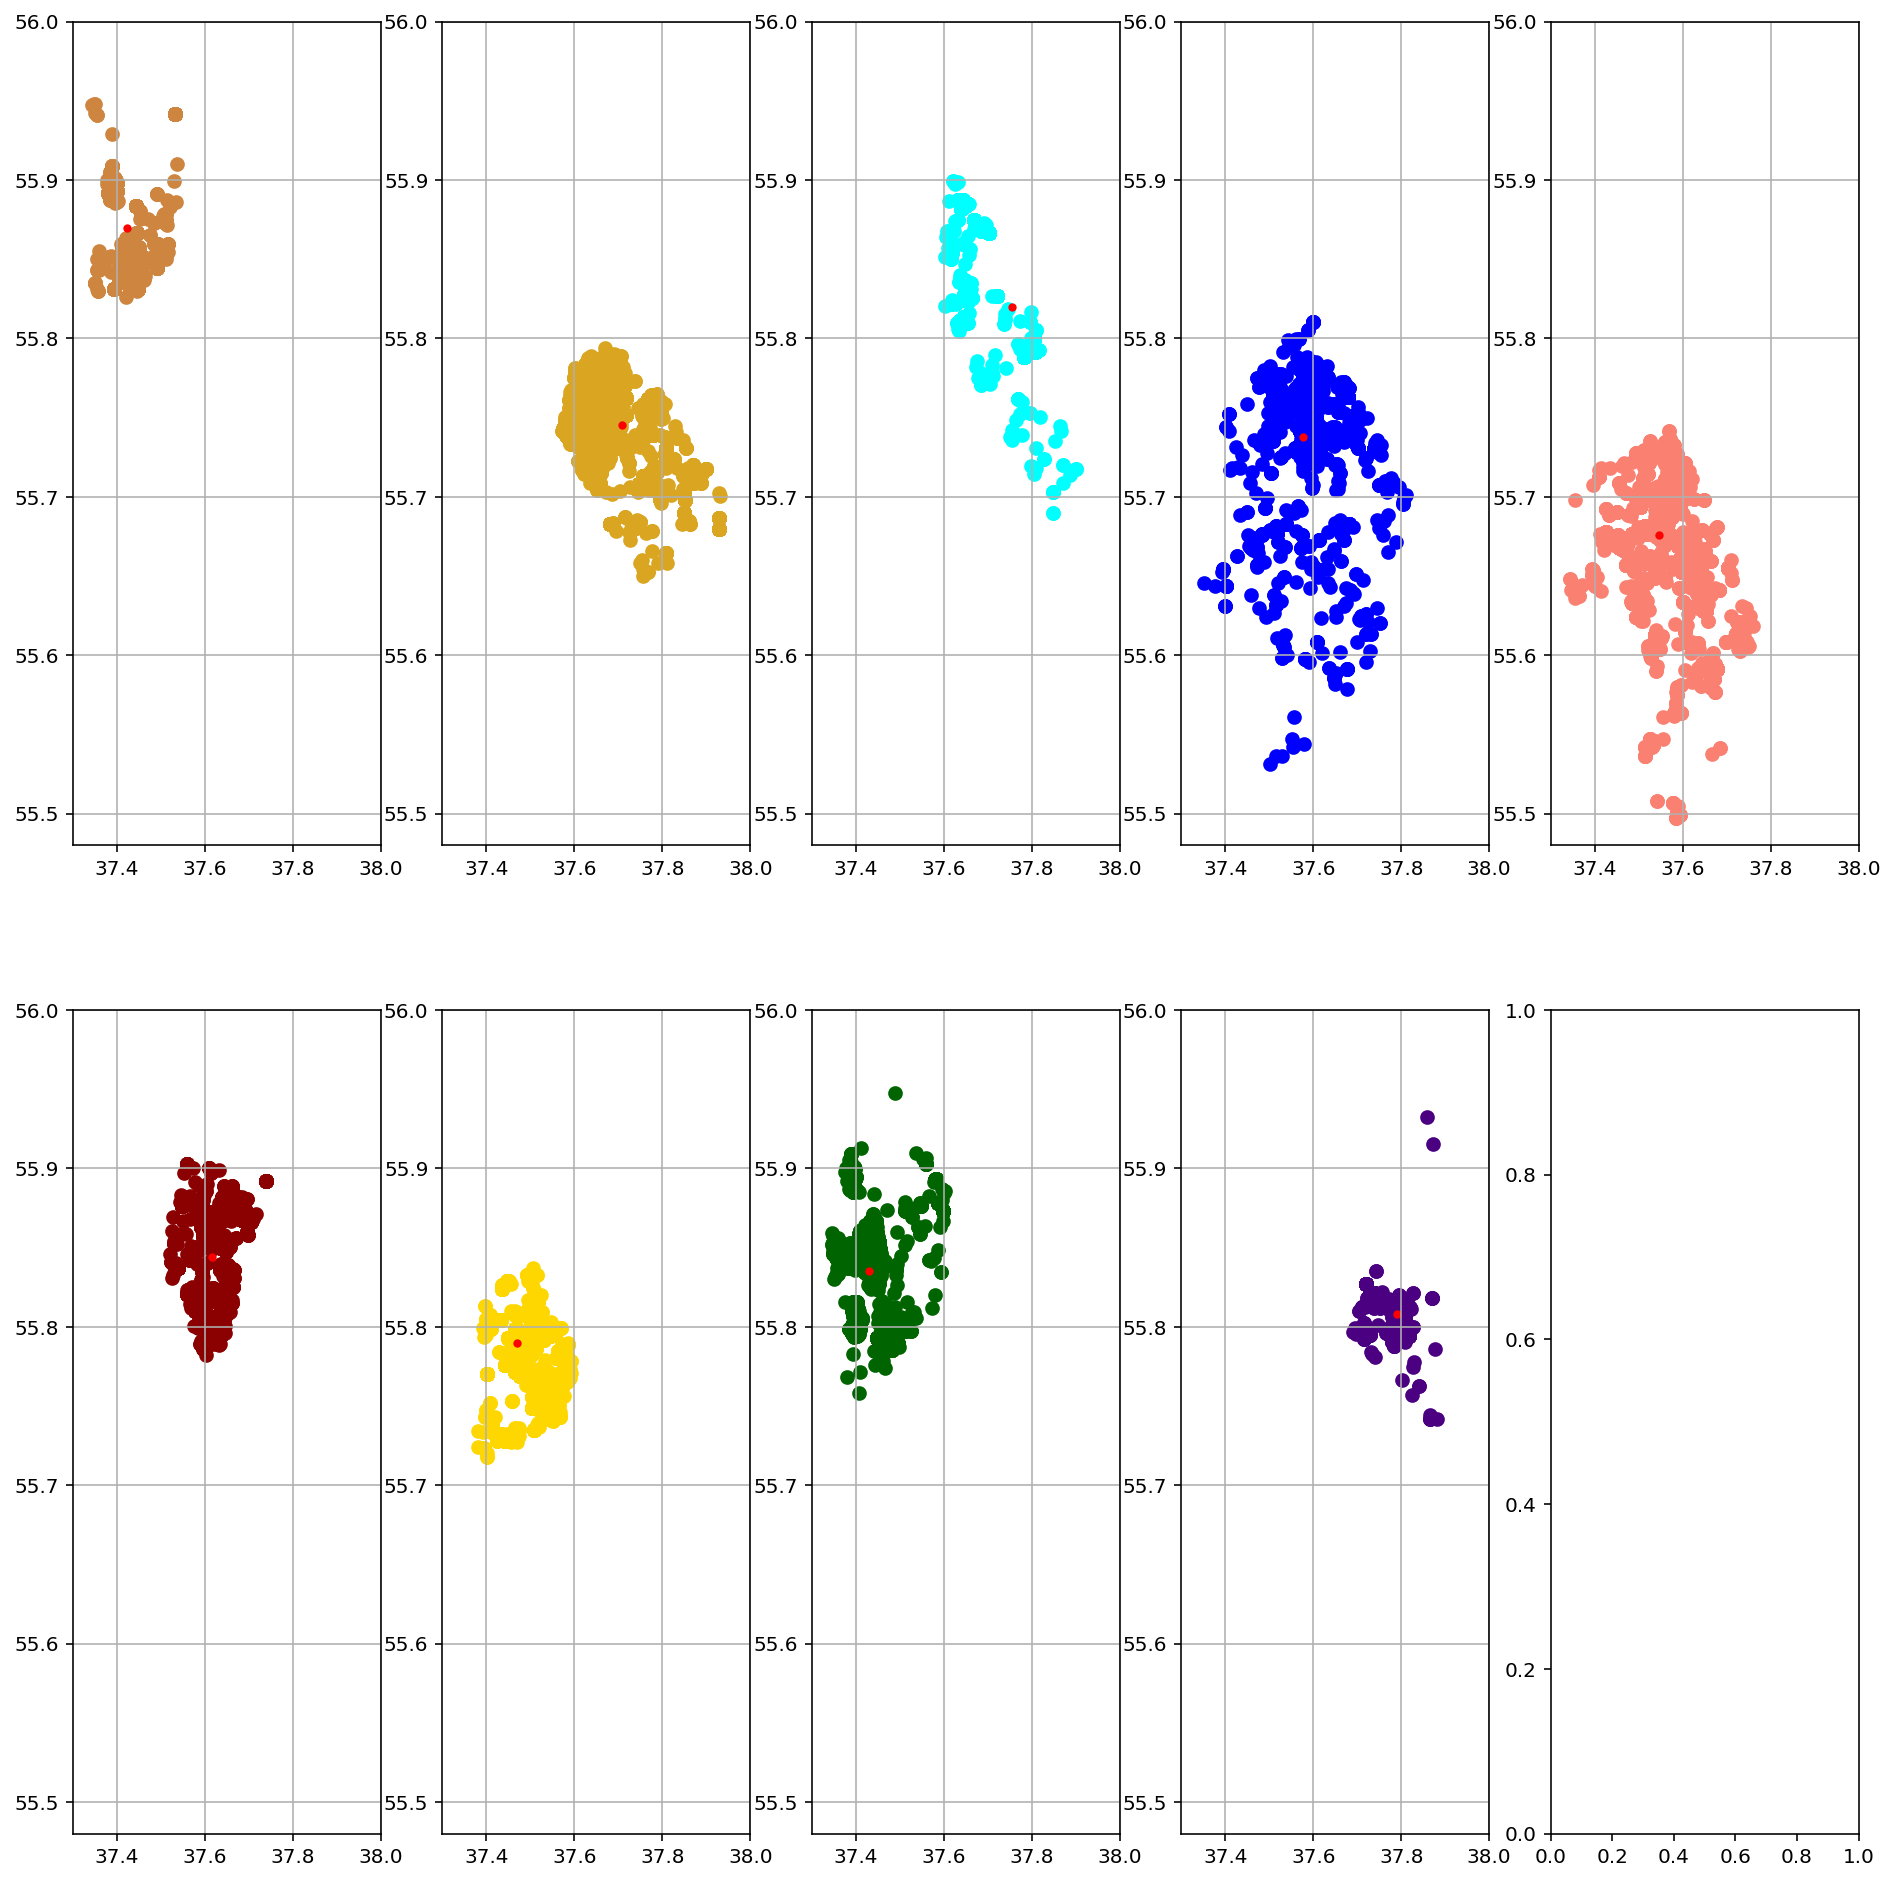

In [103]:
calc_and_draw(KMeans(n_clusters=9, random_state=42, tol=10, max_iter=300), 9, [])

Тот же алгоритм, показываем только районы 2 и 8.

Определено кластеров: 9


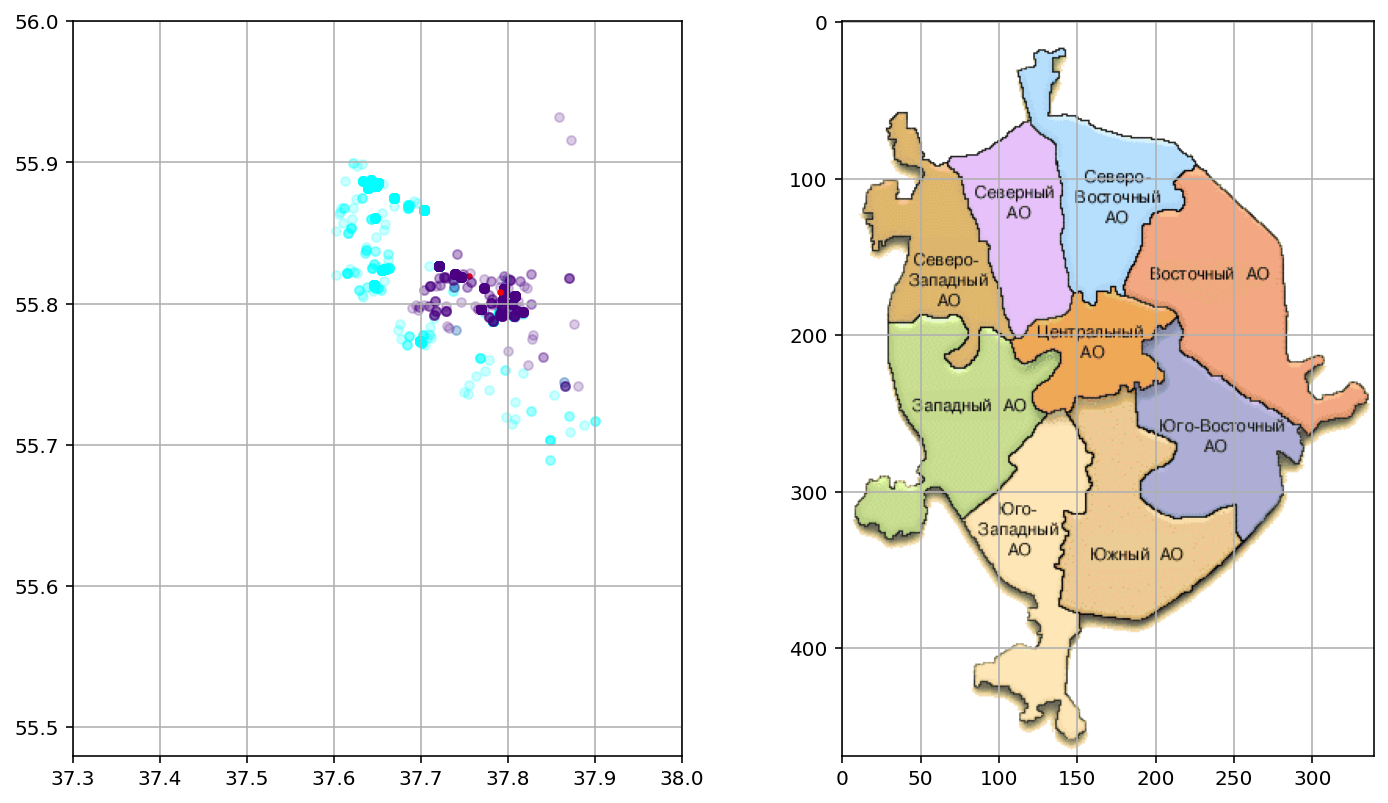

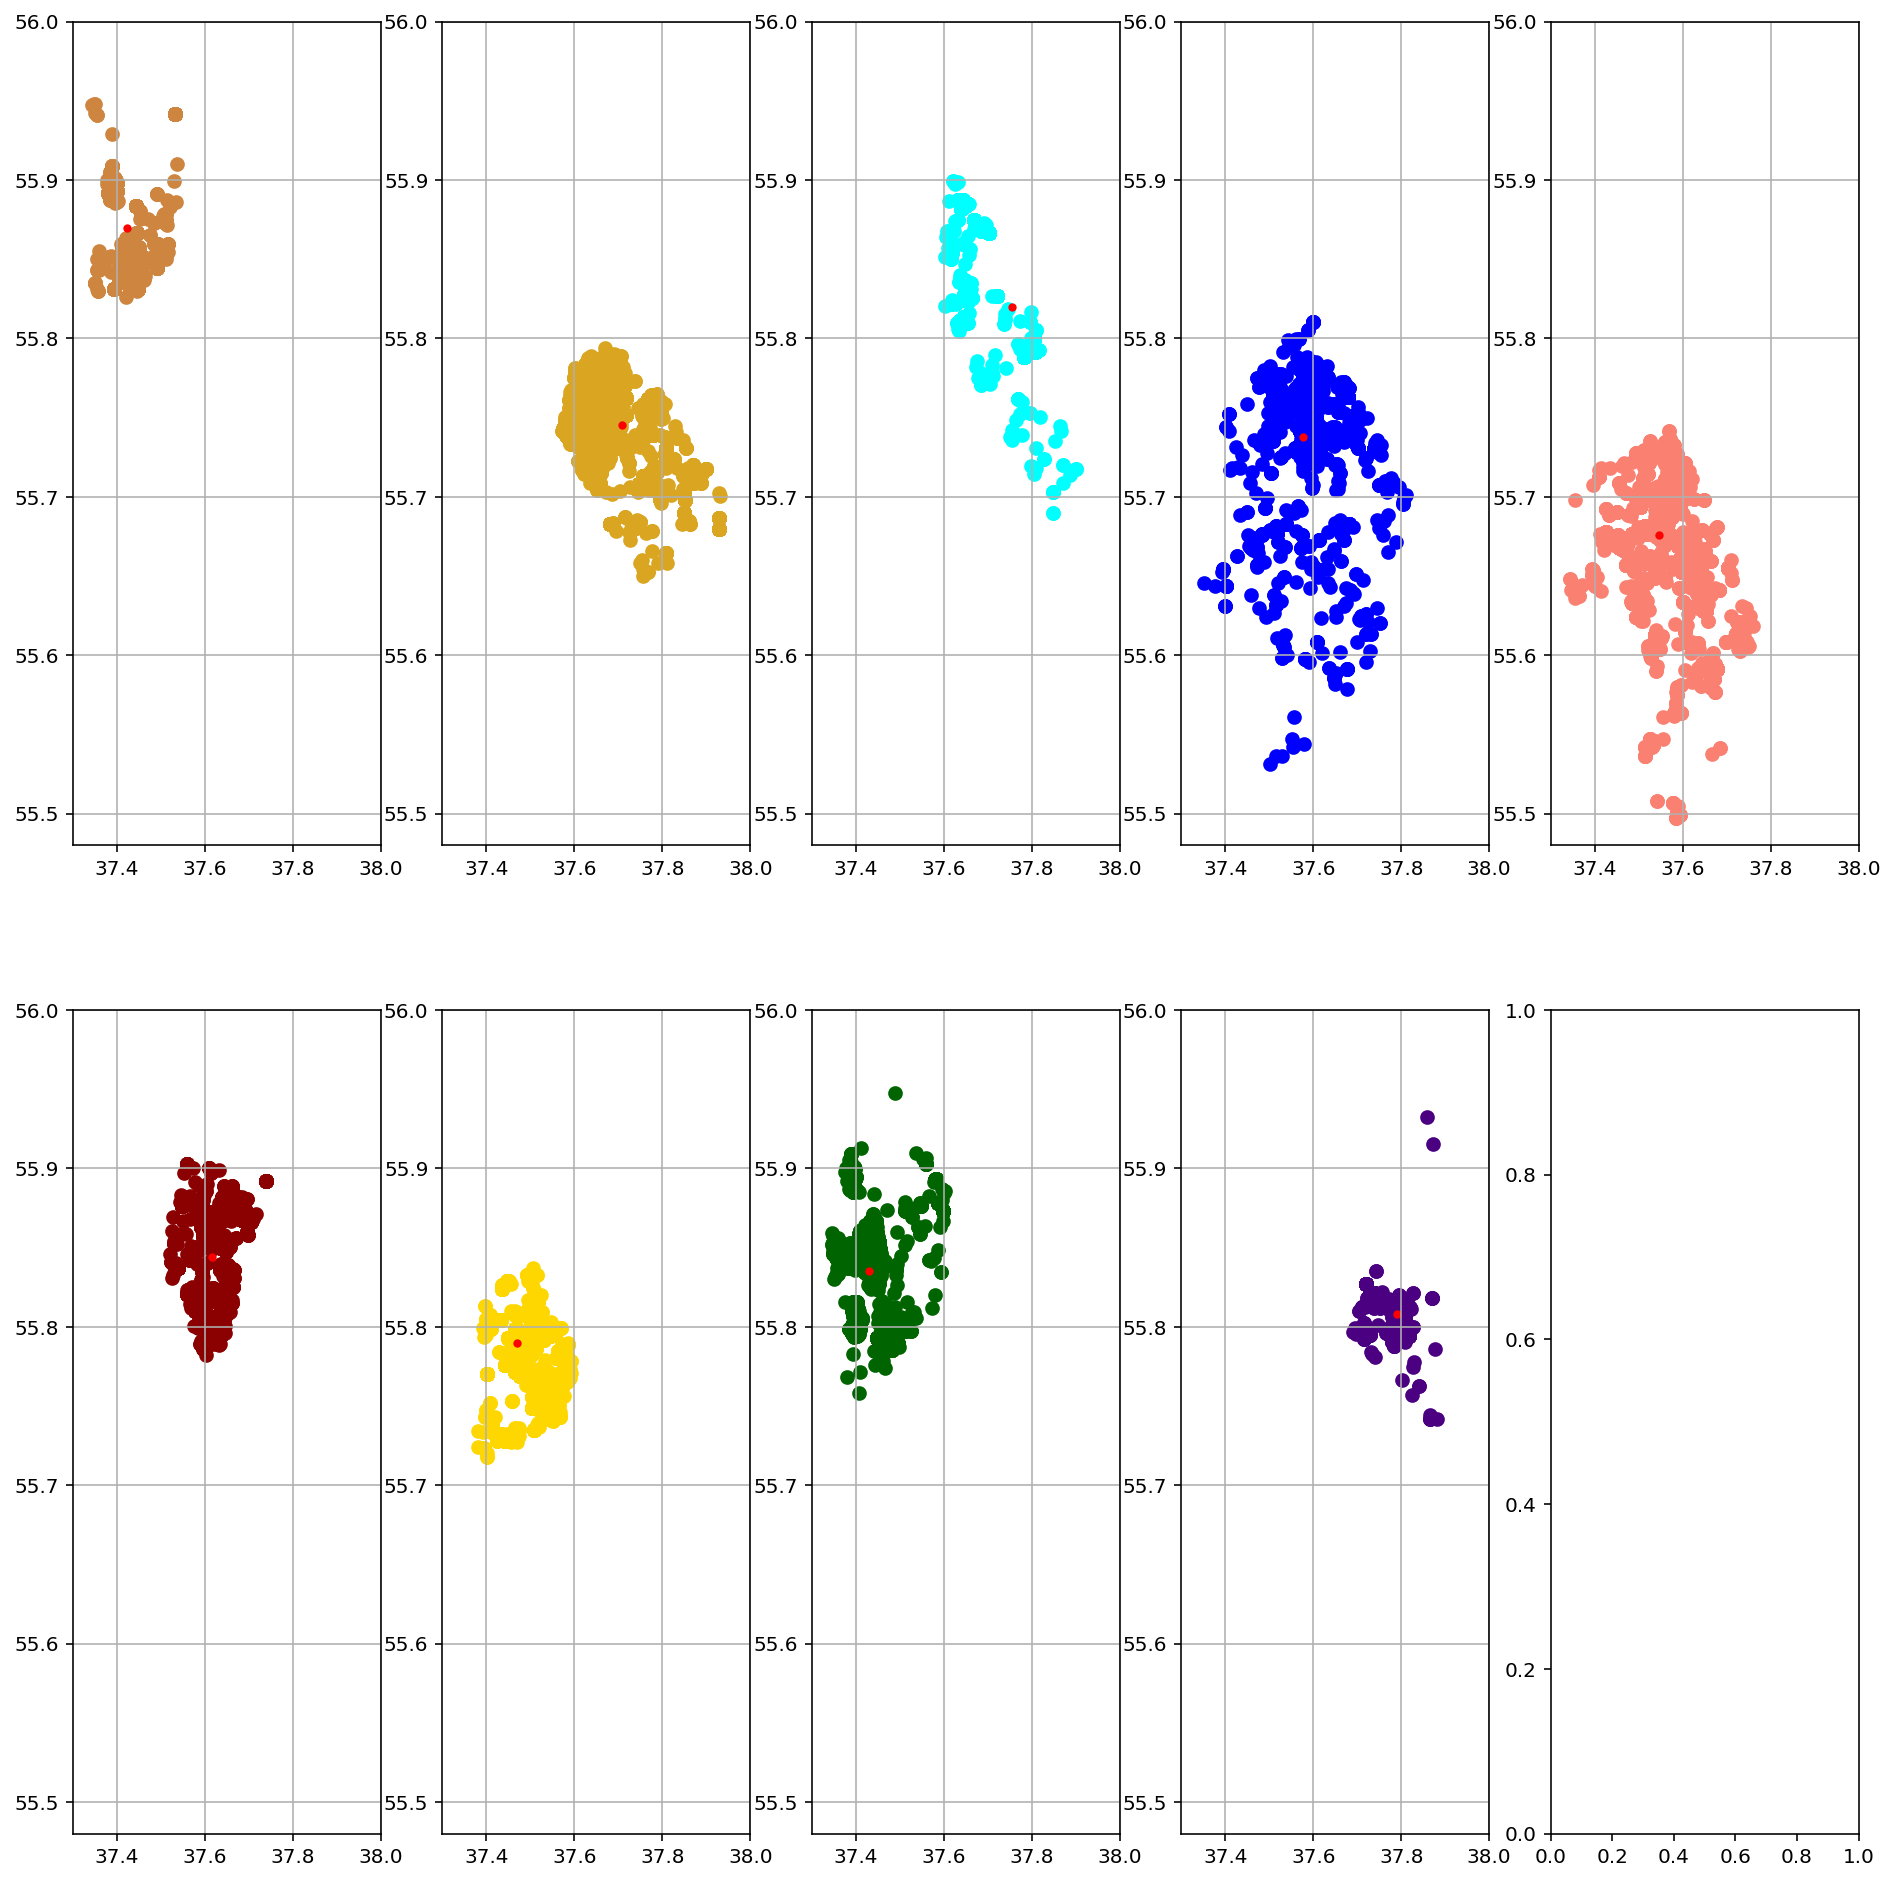

In [104]:
calc_and_draw(KMeans(n_clusters=9, random_state=42, tol=10, max_iter=300), 9, [2, 8])

Только голоса за.

Определено кластеров: 9


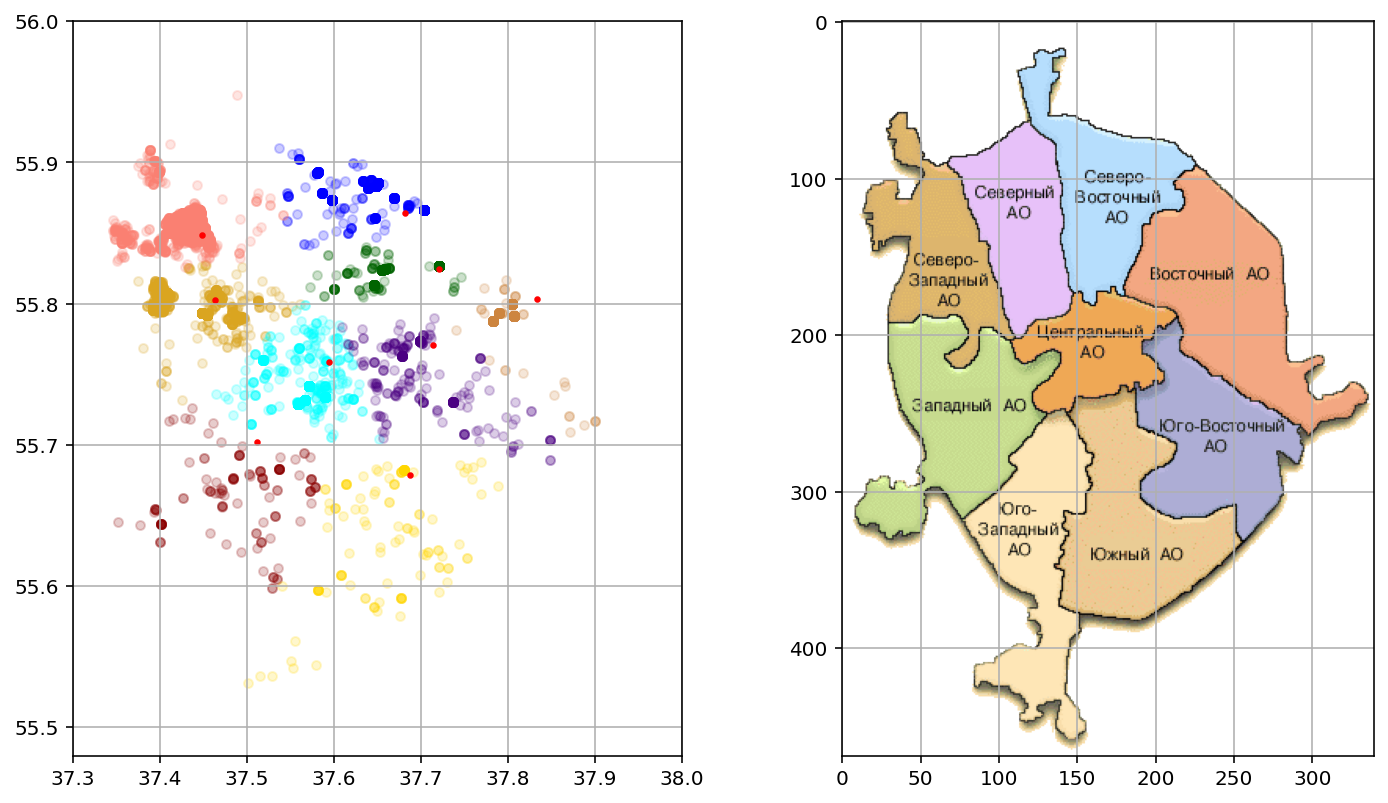

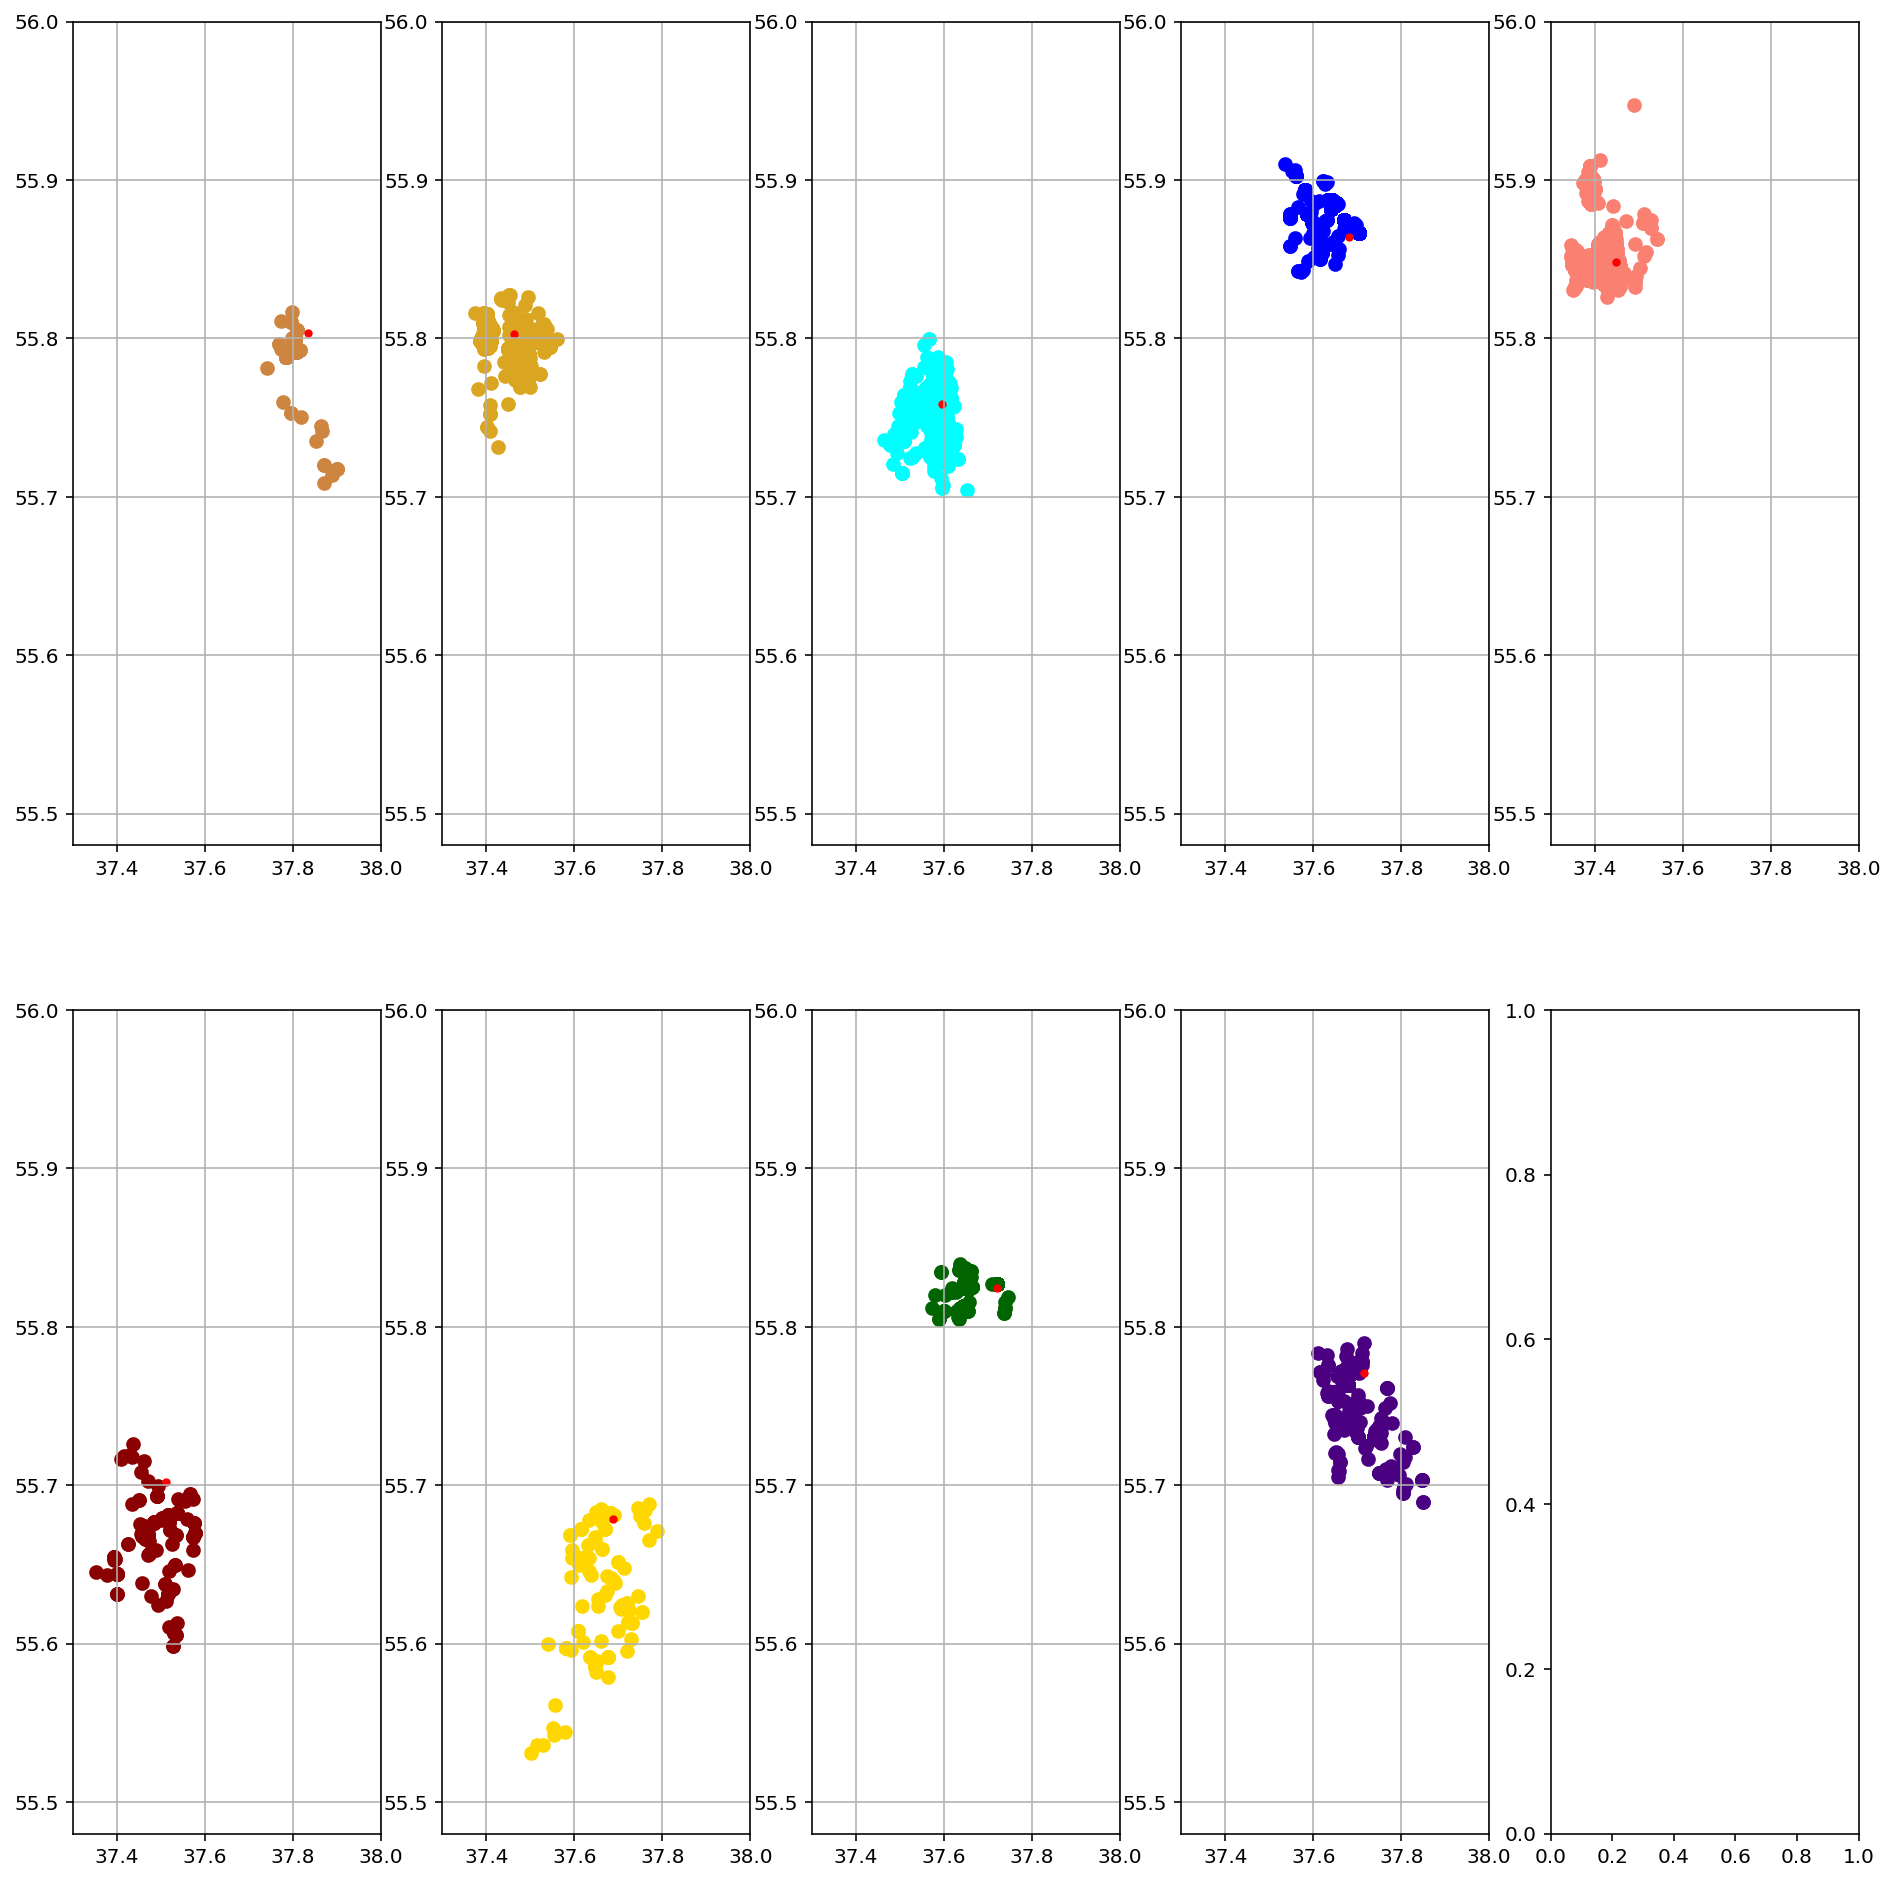

In [105]:
calc_and_draw(KMeans(n_clusters=9, random_state=42, tol=10, max_iter=300), 9, [], 'yes')

Смотрим, что покажет алгоритм DBSCAN -- ничего хорошего.

Определено кластеров: 6


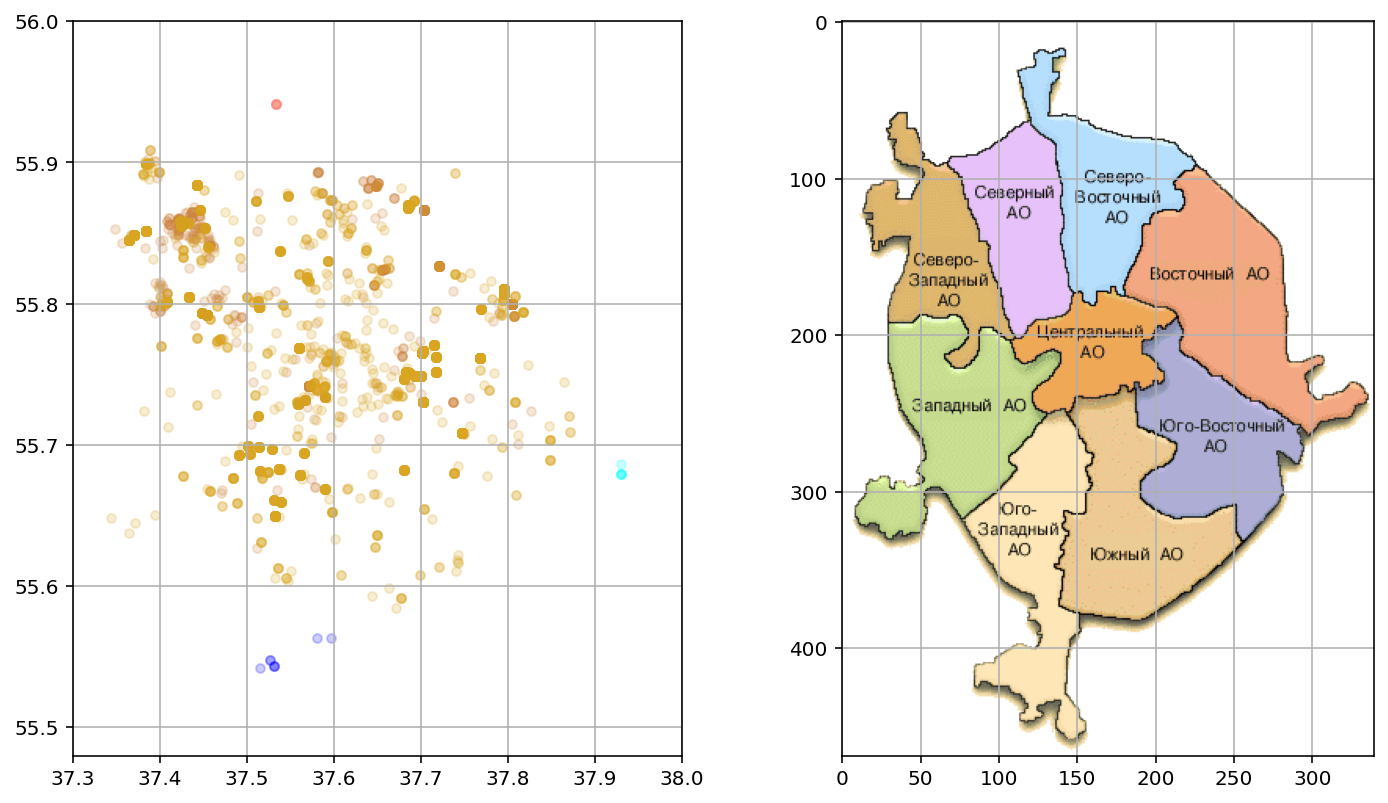

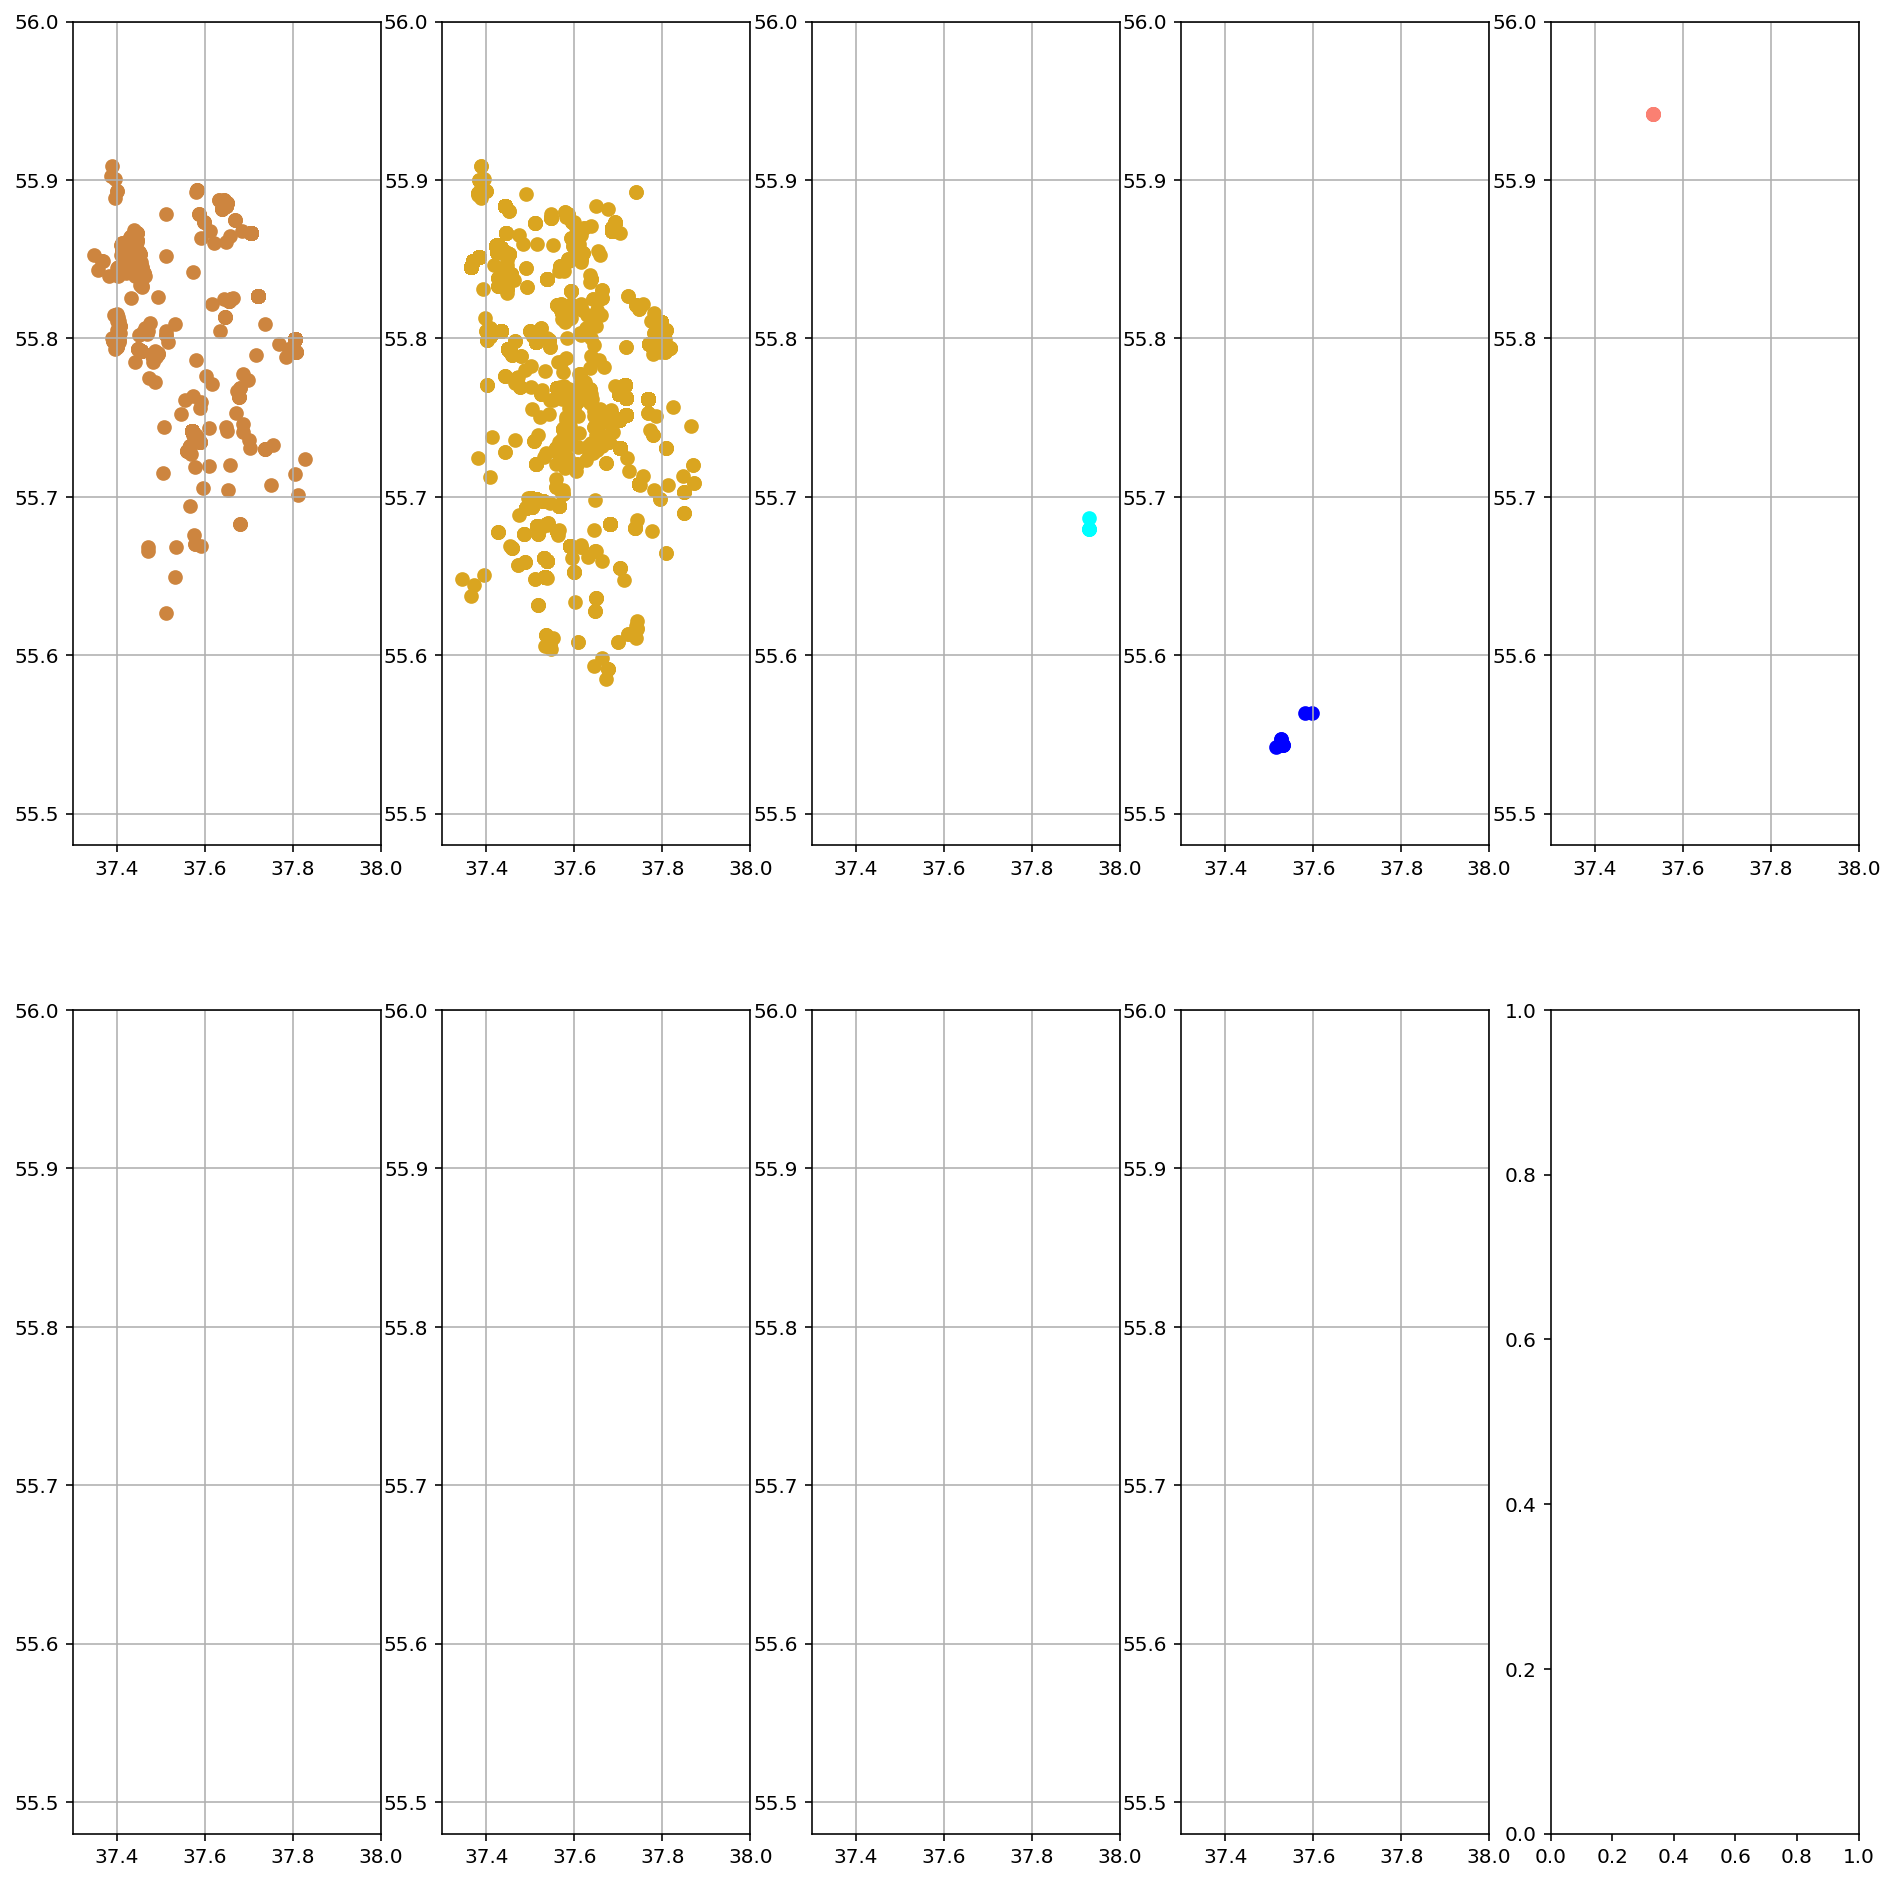

In [112]:
calc_and_draw(DBSCAN(eps=0.5), 9, [])

Теперь проверим AgglomerativeClustering(n_clusters=9). Похоже на KMeans.

Определено кластеров: 9


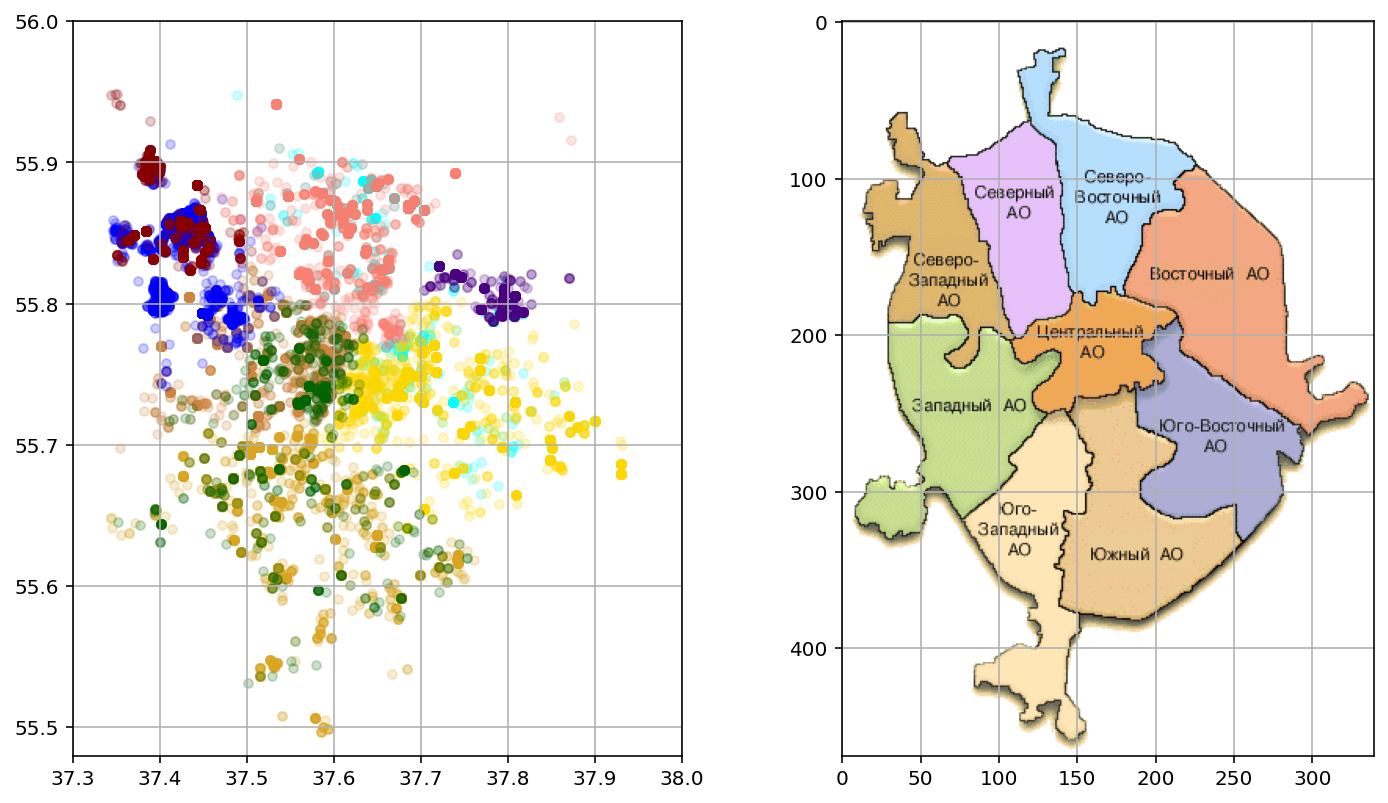

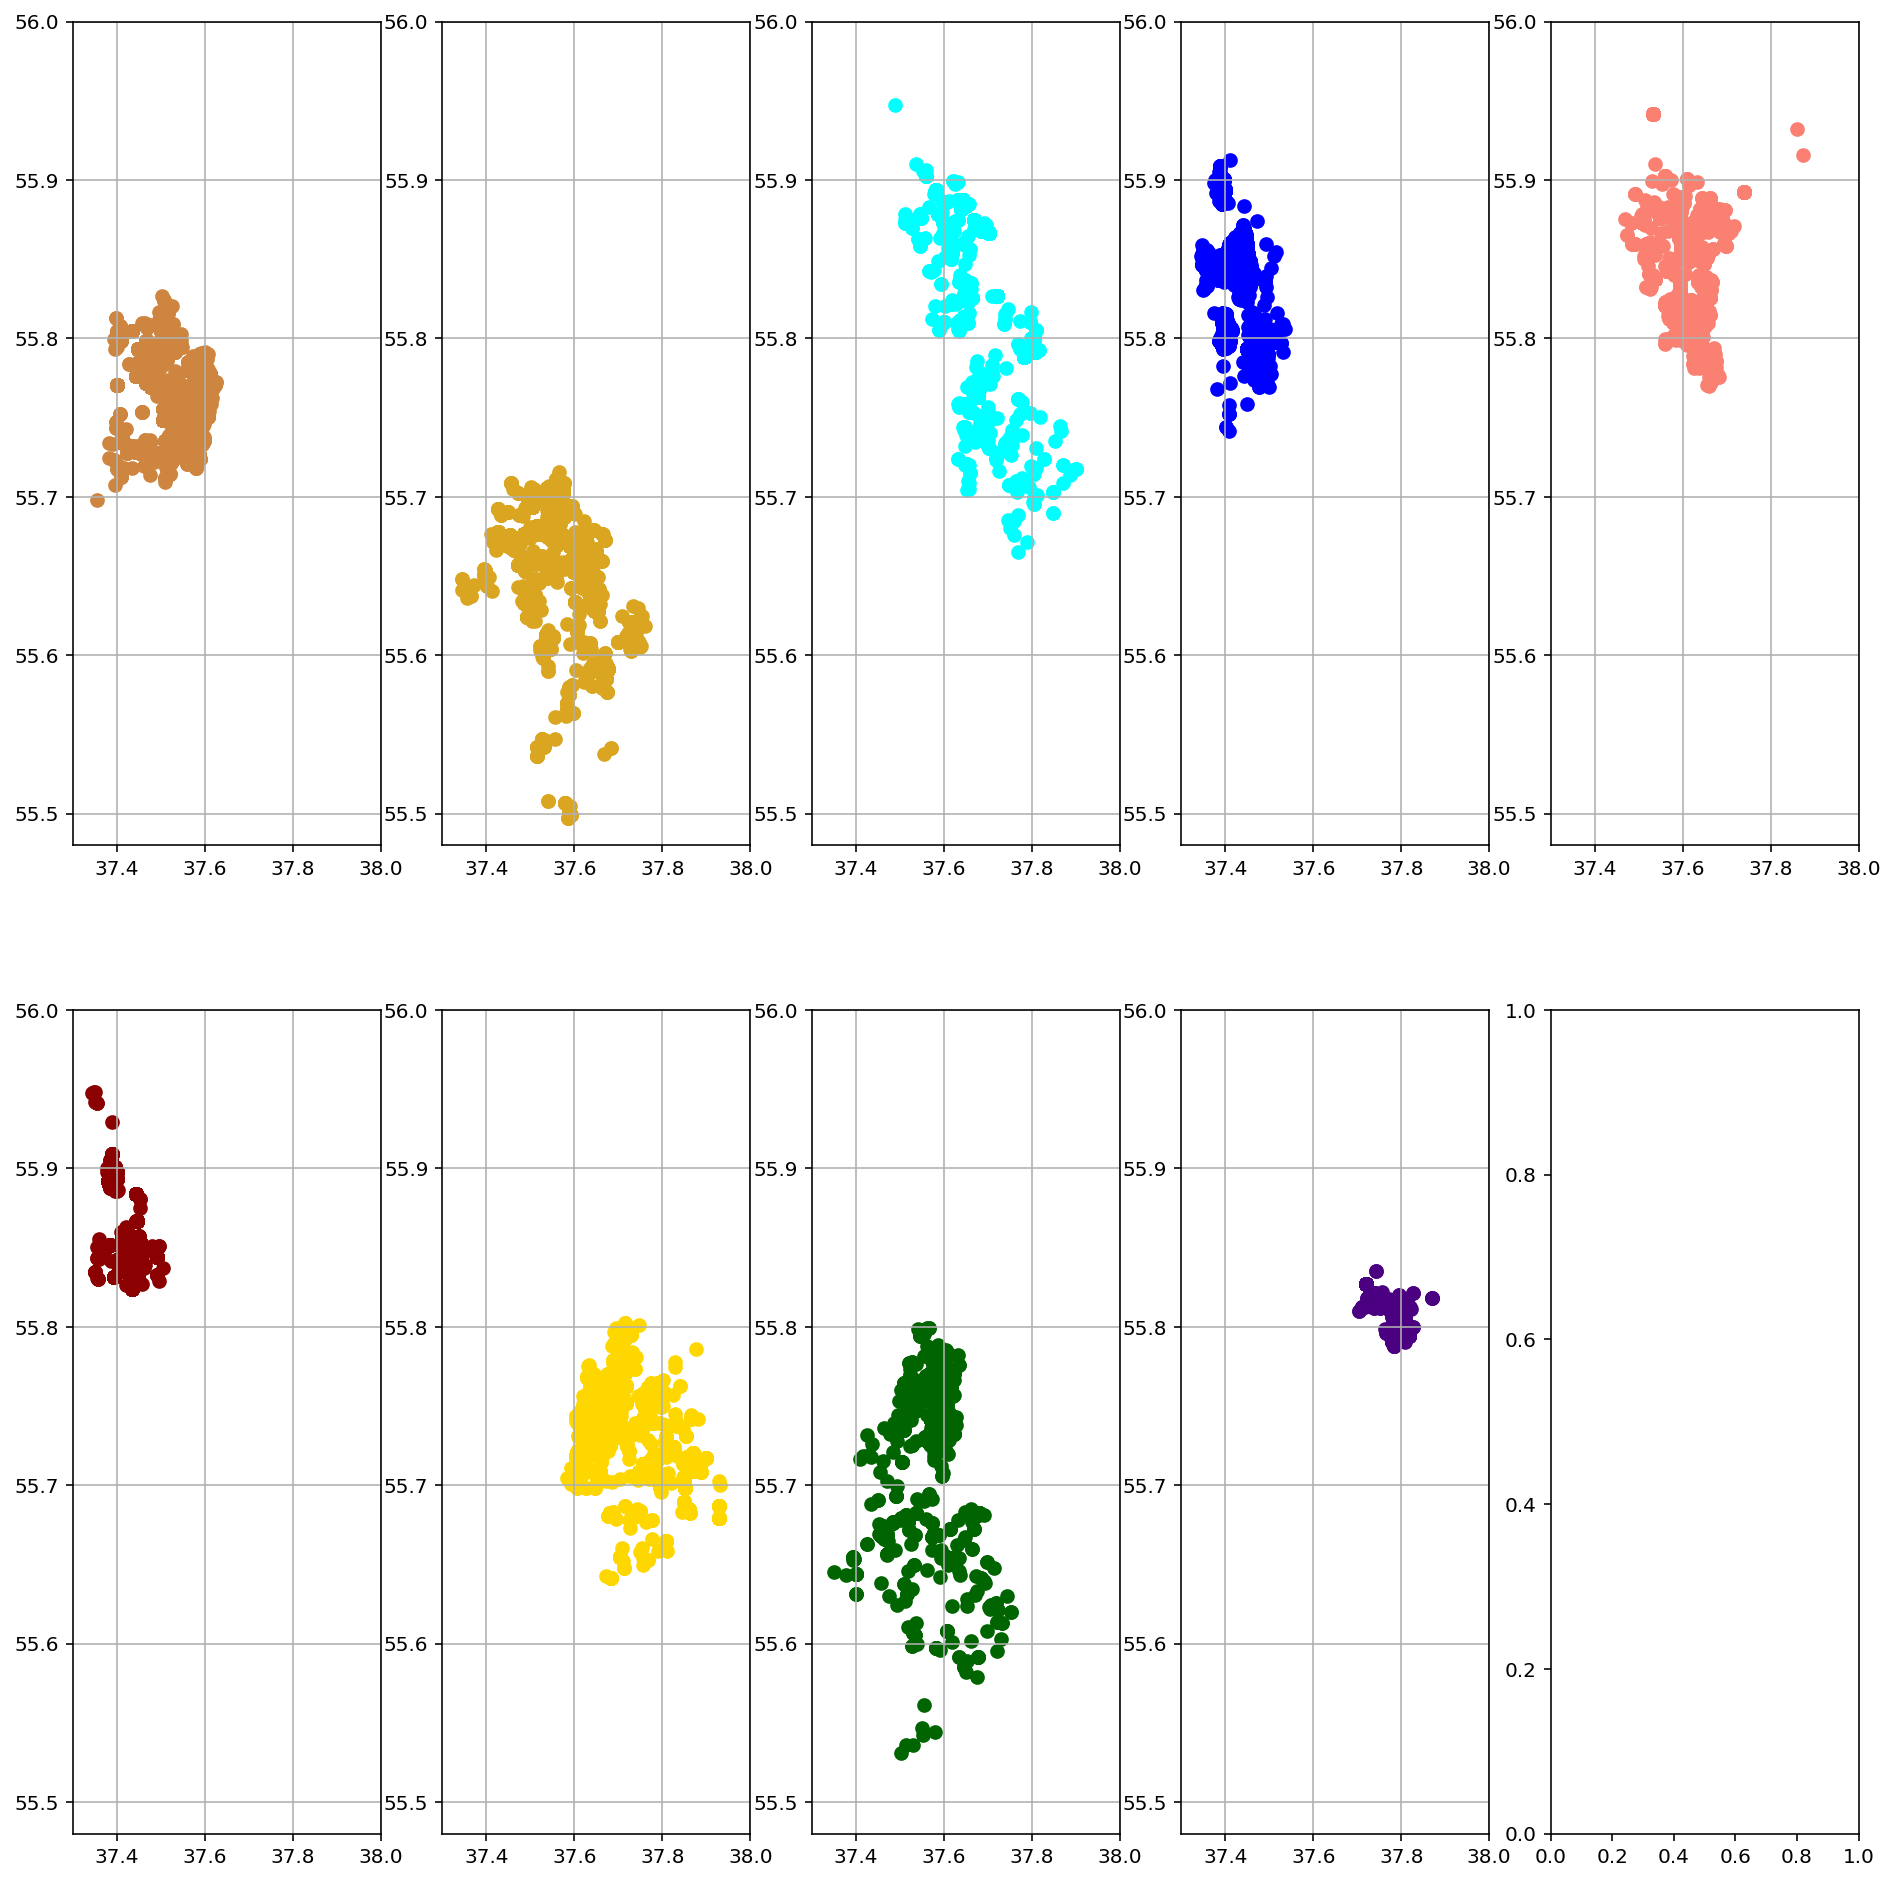

In [107]:
calc_and_draw(AgglomerativeClustering(n_clusters=9), 9, [])

Для AffinityPropagation надо подрезать данные, иначе не хватит памяти.

In [108]:
data = data[0:5000]
data_scaled = data_scaled[0:5000]

Определено кластеров: 1


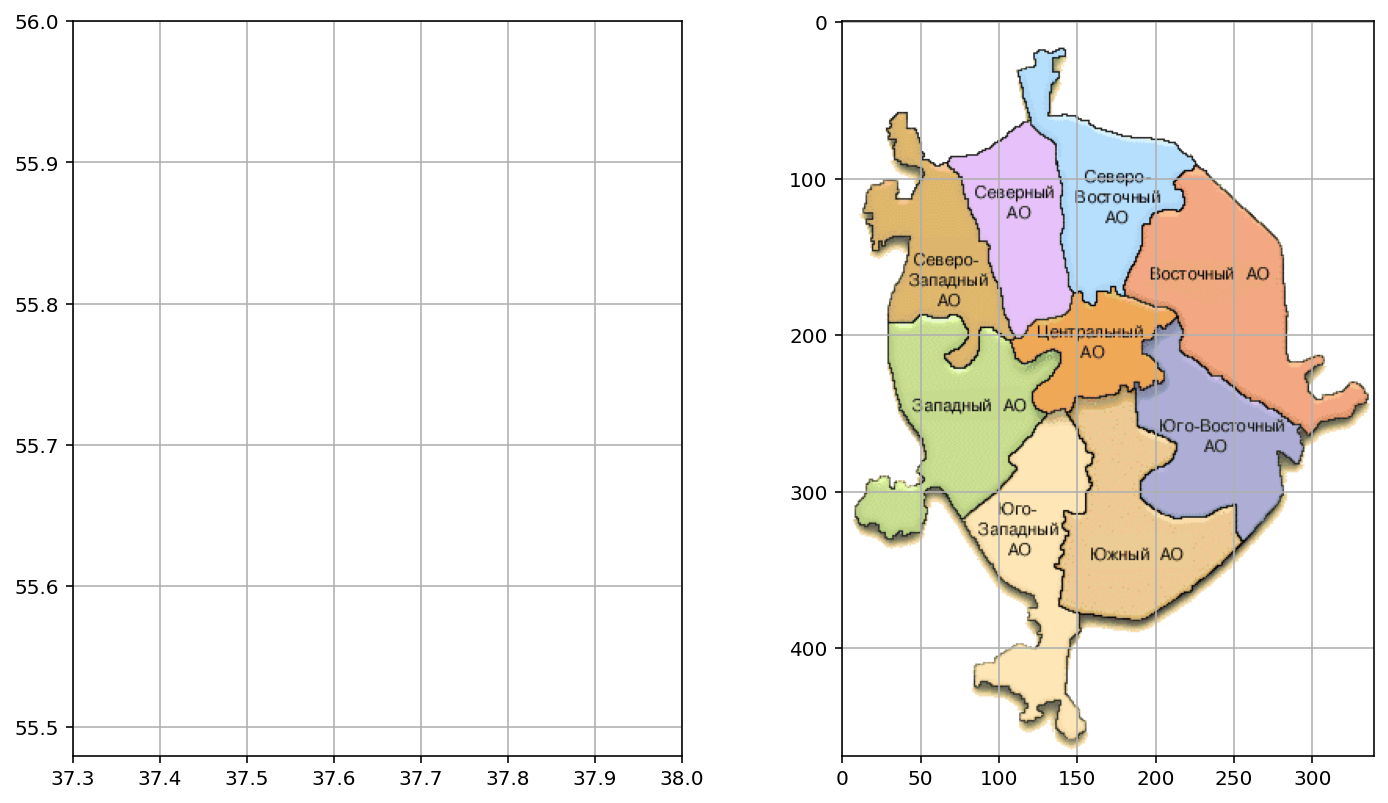

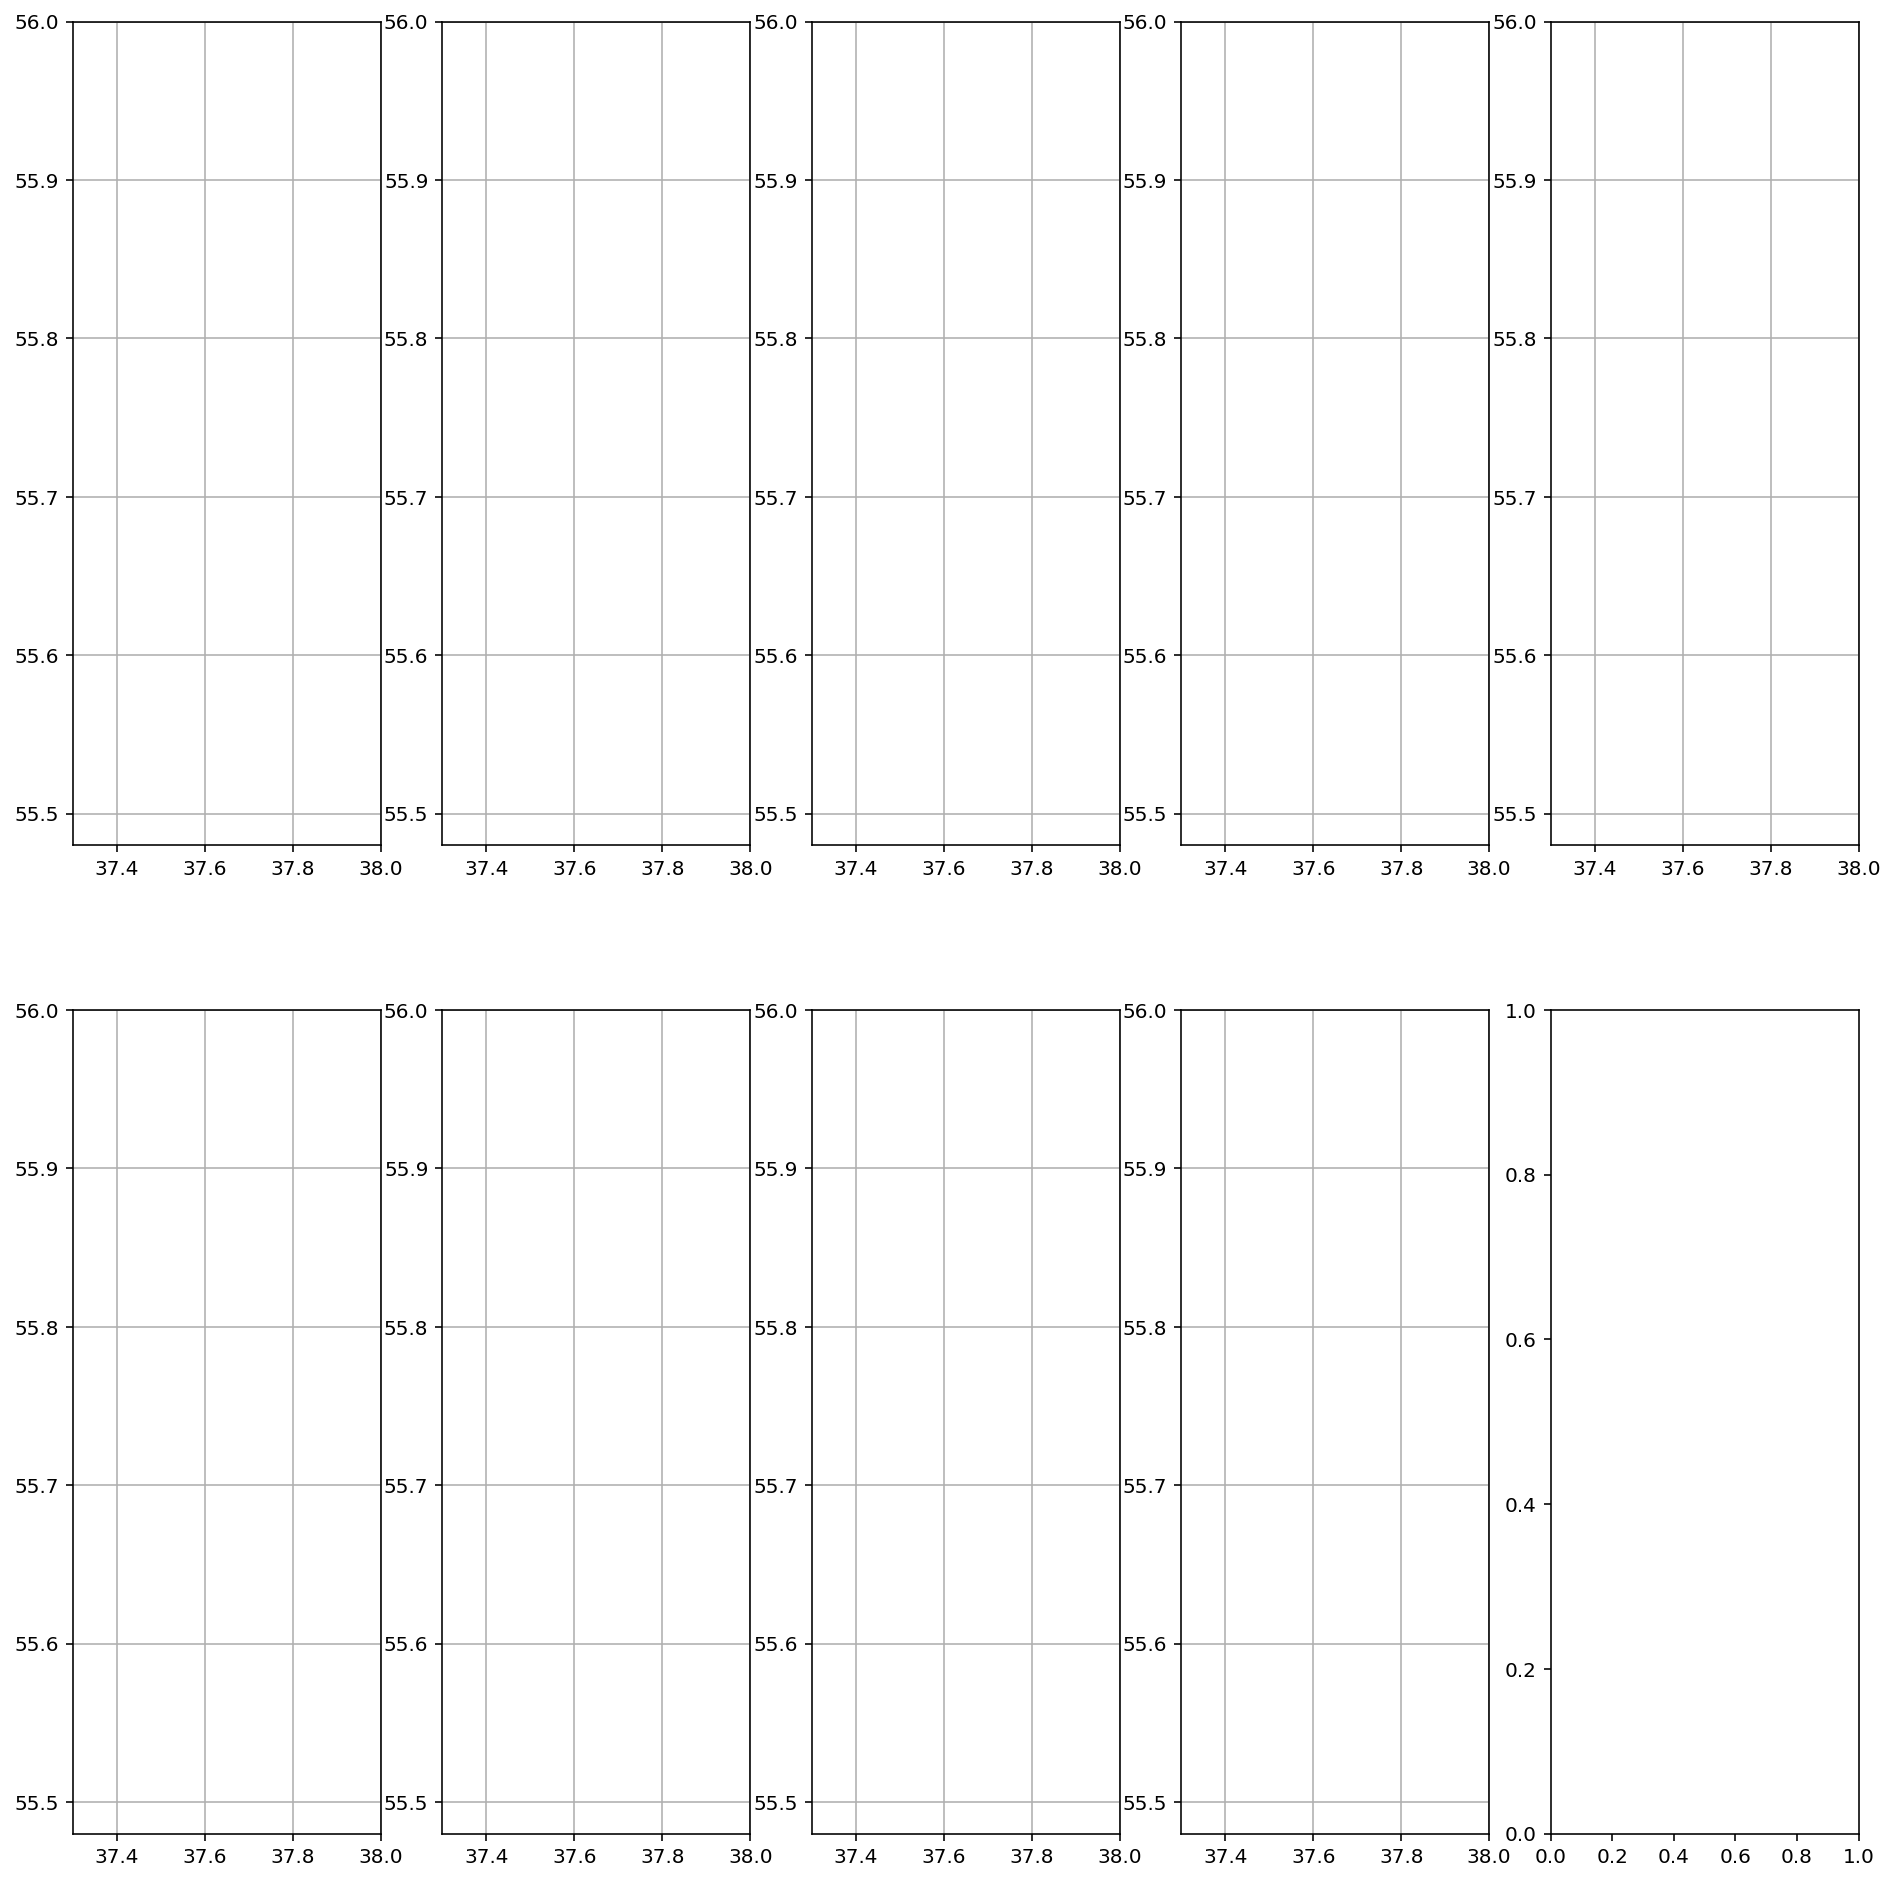

In [114]:
calc_and_draw(AffinityPropagation(damping=0.9), 9, [])